In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from tqdm.notebook import tqdm, trange

In [10]:
%load_ext autoreload
%autoreload 2

from hex_show import *
from hex_pathfinding import *
from hex_helpers import *
from hex_minmax import *
from hex_train_helpers import *
from hex_transfer import *

bsize=13
N=13

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from collections import namedtuple

gamestate = namedtuple('gamestate', 'b, p, v, addv', defaults=[None, None, 0, []])

## Initialisierung

In [12]:

class RandomPlayer(MiniMax):
    @staticmethod
    def findmove(board):
        while True:
            k = np.random.randint(N**2)
            if board[divmod(k,N)]==0:
                return divmod(k,N)
            
            
def ClassicAI(depth):
    if depth==0:
        return RandomPlayer()
    return MiniMax(maxdepth=depth)

## Pitting

In [13]:
# Funktion für das pitten zweier ai`s (Wettkampf mit n Runden)

def pit(ai1, ai2, n=20, nrnd=0, frame=0, verbose=0):
    '''Pits two ai for n rounds. First nrnd moves are randomly chosen.
    confidence: sigma interval in where you want to know one ai is better than the other
    '''
        
    if type(n) is type(None) or n==np.Inf:
        n = int(1e10)
    
    wins1 = 0
    wins2 = 0
    
    for k in range(n):

        if k%2 == 0:
            ai_red  = ai1
            ai_blue = ai2
        else:
            ai_red  = ai2
            ai_blue = ai1
            
        if k%2 == 0:
            board0 = filledboard(bsize, nrnd, frame)
            
        board = board0.copy()
        turn = (-1)**(board!=0).sum()

        while True:

            if turn>0:
                #'Reds turn'

                # Move by an AI
                #x, y = ai_red.findmove(board, True, verbose=0)
                x, y = ai_red.findmove(board)

            else:
                #'Blues turn'

                # Move by an AI
                #x, y = ai_blue.findmove(board, False, verbose=0)
                x, y = ai_blue.findmove(board)


            board[x,y] = turn
            turn *= -1
            
            if verbose>=2:
                show_board(board)


            # If someone has won
            won = winner(board)
            if won!=0:
                break

        if k%2==1:
            won *= -1
        wins1 += int(+won/2+1/2)
        wins2 += int(-won/2+1/2)
        sigma = np.sqrt(wins1*wins2/(wins1+wins2))
        
        try: ai1.clear()
        except: pass
        try: ai2.clear()
        except: pass
        
        if verbose:
            print(wins1, k+1)
        
        
    #return wins1, wins2
    return wins1/n

## Training

In [55]:

# Batch generator for neural network training

def batchgen(gamerecords, size=50, istart=0, verbose=None):
    '''size: minibatchsize
    istart, iend: Start- und Endindex der herausgegebenen Samples
    verbose: Wenn überschrieben, dann mit einem String des Batchgen Namens (z. B. Supervised)'''
    ep = 0
    iend = len(gamerecords)
    while True:
        ilist = range(istart, iend)
        ilist = np.random.permutation(ilist)
        minibatches = [ ilist[k*size:(k+1)*size] for k in range(len(ilist)//size) ]
        for mb in minibatches:
            # Network needs following informations: Board, Valid moves mask, policy, value, additional values
            bs = np.zeros((size, 5, N, N))  # board
            vds = np.zeros((size, 1, N, N)) # valid
            ps = np.zeros((size, 1, N, N))  # policy
            vs = np.zeros((size, 1))        # value
            addvs = np.zeros((size, 100))   # additional value
            for i, k in enumerate(mb):
                try:
                    be, vd, p, v, addv = gamerecords[k]
                except:
                    b, p, v, addv = gamerecords[k]  # x is in board format -> preprocess/encode and save in right way
                    be, vd = net.preprocess(b)
                    gamerecords[k] = be, vd, p, v, addv
                bs[i] = be
                vds[i,0] = vd
                #pi, pj = p
                #ps[i, 0, pi, pj] = 1
                ps[i] = p
                vs[i] = v
                addvs[i] = addv
            yield bs, vds, ps, vs, addvs
        if verbose:
            print(f'{verbose}: finished one epoch ({ep})!')
        ep += 1
        
        
def ensemble(nets, *args):
    num = len(nets)
    ps, vs = 0, 0
    for i in range(num):
        with torch.no_grad():
            p, v = nets[i](*args)
            
            ps += p/num
            vs += v/num
    return ps, vs
        

def train(net, gamerecords, gamerecords_legacy=[], iterations=4000, teachers=[], aug_ds=True, cons_ds=False, verbose=0):
    '''Trainiert das Netz
    aug_ds: Augmentation durch Drehspiegelung (Flip in x und y)
    cons_ds: Konsistenzbedingung unter Drehspiegelung auf dem unsupervised Set
    teacher_function: Eine Funktion, nach der auf dem unsupervised Set das Netzwerk trainiert wird. Wenn None wird der MTeacher genutzt'''

    #if net is None:
    #    net = Net(n=64)
    optimizer = torch.optim.Adam(lr=3e-4, params=net.parameters(), weight_decay=1e-4)
    bg_s = batchgen(gamerecords, istart=500, size=200)                 #### istart erhöhen um valbatch zu haben? für early stopping?
    bg_u = batchgen(gamerecords_legacy, size=150)
    bg_v = batchgen(gamerecords[:500], size=500)
    BCE = nn.BCELoss()
    MSE = nn.MSELoss()
    L1Loss = nn.L1Loss()
    L1L2 = lambda p, t: MSE(p,t) + L1Loss(p,t)
    LogLoss = lambda yp, yt: torch.mean(-yt*torch.log(yp+1e-4)) * 10
    plosses, vlosses, semlosses = ( [] for l in range(3) )
    semloss = 0
    
    def getValloss():
        # Valbatch
        b, vd, tp, tv, taddv = next(bg_v)
        b, vd, tp, tv, taddv = batch2torch(b, vd, tp, tv, taddv)

        do, net.dropout = net.dropout, 0
        pp, pv, pvtuned, bigV = net(b, vd)
        ##bigV, pvtuned = net.mix(y)
        net.dropout = do
        return LogLoss(pp.reshape(-1), tp.reshape(-1)), MSE(bigV[:,0], tv[:,0]).item()


    # Trainings loop
    for k in trange(iterations):

        # ==== Supervised step ====
        b, vd, tp, tv, taddv = next(bg_s)
        b, vd, tp, tv, taddv = batch2torch(b, vd, tp, tv, taddv)
        
        
        if aug_ds:
            if np.random.rand()<0.5:
                b = torch.flip(b, [2, 3])
                vd = torch.flip(vd, [2, 3])
                tp = torch.flip(tp, [2, 3])
            
        pp, pv, pvtuned, bigV = net(b, vd)
        ###bigV, pvtuned = net.mix(y)
        
        # For softmax LogLoss, for sigmoid BCE
        #_loss = LogLoss(pp.reshape(-1), tp.reshape(-1)) + L1L2(pv[:,1:13], taddv[:,:12]) + 1e-3*MSE(bigV[:,0], tv[:,0]) + 1e-3*MSE(pvtuned[:,1:13], torch.stack(12*[tv[:,0]], -1))
        
        ploss = LogLoss(pp.reshape(-1), tp.reshape(-1))
        vloss = L1L2(1.02*pv[:,:], taddv[:,:]) + MSE(bigV[:,0], tv[:,0]) + MSE(1.02*pvtuned[:,:], torch.stack(100*[tv[:,0]], -1))
        _loss = ploss + vloss
        ploss = ploss.item()
        vloss = MSE(bigV[:,0], tv[:,0]).item()
        
        '''
        if teachers:
            epp, epv = ensemble(teachers, b, vd) ###
            epv = epv[:,0]
            semloss = 2*(MSE(pp, epp) + MSE(pv, epv))###
            _loss += semloss
            semloss = semloss.item()'''
        
        
        '''
        # ==== Unsupervised step ====
        if teachers and len(gamerecords_legacy)>0:
            b1, vd1, _, _ = batch2torch(*next(bg_u))

            ## Drehspiegelung als augmentation
            b2  = torch.flip(b1,  [2, 3])
            vd2 = torch.flip(vd1, [2, 3])

            # --> welches Netzwerk ?
            pp1, pv1 = net(b1, vd1)
            pp2, pv2 = ensemble(teachers, b2, vd2) ###
            
            pp2 = torch.flip(pp2, [2, 3]) ## flip back
                
            semloss = 2*(MSE(pp1, pp2) + MSE(pv1, pv2) + L1Loss(pv1, pv2))###
            _loss += 2*semloss
            semloss = semloss.item()'''

        # do the training step on the network
        _loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        # Statistic
        plosses += [ploss]
        vlosses += [vloss]
        semlosses += [semloss]
        
        
        # Verbose output, measure minimum val loss
        if len(plosses) == 100:
            pvalloss, vvalloss = getValloss()
            if verbose>=1:
                print('PLoss=%f, VLoss=%f, Pvalloss=%f, Vvalloss=%f'% (np.mean(plosses), np.mean(vlosses), pvalloss, vvalloss))
            plosses, vlosses, semlosses = ( [] for l in range(3) )
            
    #net.dropout = 0
    return net

In [52]:
#net = Net13x13()
train(net, game_rec+game_rec_leg, [], iterations=1000, verbose=1)

PLoss=0.000000, VLoss=0.841205, Pvalloss=0.000000, Vvalloss=0.723009
PLoss=0.000000, VLoss=0.836912, Pvalloss=0.000000, Vvalloss=0.752504
PLoss=0.000000, VLoss=0.831557, Pvalloss=0.000000, Vvalloss=0.735190
PLoss=0.000000, VLoss=0.835449, Pvalloss=0.000000, Vvalloss=0.733218
PLoss=0.000000, VLoss=0.826852, Pvalloss=0.000000, Vvalloss=0.730015
PLoss=0.000000, VLoss=0.828627, Pvalloss=0.000000, Vvalloss=0.733880



KeyboardInterrupt: 

In [61]:
net.alphas

Parameter containing:
tensor([[ 0.0516, -0.1732, -0.6439,  0.3845, -0.1534,  0.5874, -0.0497, -0.0773,
          0.7288,  0.1193,  0.4619, -0.0560, -0.0462, -0.5096, -0.0596, -0.0794,
          0.5199,  0.9571,  0.3856, -0.1258,  0.1568,  0.5184,  0.1338,  0.8973,
         -0.3165,  0.1027,  0.2429, -0.1541,  0.9189,  0.6933,  1.0293,  0.9067,
          1.0283,  0.9679,  0.9361,  0.4686,  0.3484, -0.0734,  0.2518,  0.1045,
          0.1452,  0.3880,  0.1011,  0.1244,  0.1273,  0.3839,  0.1172,  0.1210,
          0.1193,  0.2553,  1.0150,  0.1084,  0.1106,  0.1185,  0.6210,  0.2146,
          0.0604,  0.0845,  0.3007, -0.3006,  0.0633,  0.0829,  1.0894,  0.0973,
          0.1050,  0.5637,  1.0721,  0.0431,  0.8933,  1.0755,  1.1815,  0.0548,
          0.1862,  0.0556,  0.0838,  0.0610, -0.3221,  0.0595,  0.0906,  0.5539,
         -0.2469,  0.0666,  0.0684, -0.1392,  0.4513,  0.0530,  0.0817, -0.1014,
         -0.2812,  0.4223,  0.8232,  0.9045,  0.9923,  0.1385, -0.0716,  0.2991,
      

In [62]:
net.alphasV.weight

Parameter containing:
tensor([[ 0.8709,  0.0553,  0.1783,  0.0285,  0.1128, -0.0300,  0.0517, -0.1350,
          0.0107, -0.0104, -0.1139, -0.0180, -0.0645, -0.0755, -0.0154, -0.0775,
          0.0142, -0.0509,  0.0521, -0.0151, -0.1289,  0.0065,  0.0375, -0.0259,
         -0.0293,  0.0352, -0.0610,  0.0316, -0.0778, -0.0239, -0.0553, -0.0370,
         -0.0254,  0.0265,  0.0378, -0.1535, -0.0785,  0.0046,  0.0174,  0.0988,
         -0.0189,  0.0521, -0.0311, -0.0396, -0.0279,  0.1232,  0.1206, -0.0470,
         -0.0315, -0.0564, -0.0937,  0.1128, -0.0875,  0.1234,  0.0595,  0.0186,
          0.0436, -0.0094, -0.0516, -0.0311, -0.0603,  0.0150,  0.0625,  0.1091,
          0.0568, -0.1687, -0.0396, -0.0070, -0.0654,  0.0593, -0.0090,  0.0318,
         -0.0396,  0.1394,  0.0849,  0.1198,  0.0414,  0.0201,  0.0173,  0.0283,
         -0.0792, -0.0142, -0.0404,  0.0156, -0.0711,  0.0794, -0.0111, -0.0453,
         -0.0903,  0.1199, -0.0478, -0.0600,  0.0110, -0.0089, -0.1414, -0.1077,
      

### Selfplay

In [15]:
from hex_minmax import *
from hex_nnet import *
from hex_mcts import *


import pickle


def selfplay(ai, ngames=1000, verbose=0):
    
    red_wins = 0
    blue_wins = 0
    games_record = []

    # Iterator with tqdm??
    iter = range(ngames)
    if verbose>=1:
        iter = tqdm(iter)
        
    # Play n games!
    for k in iter:

        ##ai = MultiMCTS(nparallel=5, nsearches=50, path='net_train_selfplay.dat')
        ai.eta = 0.3
        ai_red = ai
        ai_blue = ai

        #### #  Spiele aufzeichnen
        boards_moves_record = []
        ####

        #board = np.zeros((bsize,bsize), int)
        board = filledboard(bsize, 3, FRAME)
        turn = getturn(board)

        while True:

            #show_board(board)
            #plt.show()


            if turn>0:
                #print('Reds turn')

                # Move by an AI
                x, y = ai_red.findmove(board)


            else:
                #print('Blues turn')

                # Move by an AI
                x, y = ai_blue.findmove(board)

            if turn > 0:
                boards_moves_record += [(board.copy(), (x,y), turn)]
            else:
                boards_moves_record += [(-board.T.copy(), (y,x), turn)]
                

            board[x,y] = turn
            turn *= -1



            # If someone has won
            won = winner(board)
            if won!=0:
                #path = winning_path(board)
                if verbose >= 2:
                    if won==+1:
                        print('Red has won!')
                    else:
                        print('Blue has won!')
                if verbose >= 3:
                    show_board(board)
                    show_path(path)
                    plt.show()
                break

        red_wins  += int(+won/2+1/2)
        blue_wins += int(-won/2+1/2)

        winpath = winning_path(board)

        # Spiele aufzeichnen
        boards_won_record = [ (b, m, t*won) for b, m, t in boards_moves_record ]
        ## irgendwann winning path hinzufügen?

        games_record += boards_won_record
        
    return games_record

In [7]:
from hex_minmax import *
from hex_nnet import *
from hex_mcts import *

bsize = 13
N = 13


import pickle

boards = None
def selfplay_batched(ai, nstates=1000, frame=0, verbose=0):
    
    global boards
    bnum = ai.nparallel
    game_records = []
    
    ai.eta = 0.3

    # Iterator with tqdm??
    if verbose>=1:
        pbar = tqdm(total=nstates)
        
    newboard = lambda: filledboard(bsize, count=3, frame=frame)
    if type(boards) is type(None):
        boards = [ newboard() for _ in range(bnum) ]
    turns = [ getturn(brd) for brd in boards ]
    records = [ [] for _ in range(bnum) ]
    
    
    #completedgames = 0
    #while completedgames < ngames:
    while len(game_records) < nstates:
        
        moves = ai.findmove(boards)
        for b in range(bnum):
            turn = turns[b]
            x, y = moves[b]
            records[b] += [(boards[b].copy(), (x, y), turn)] if turn > 0 else \
                          [(-boards[b].T.copy(), (y, x), turn)]
            boards[b][x, y] = turns[b]
            turns[b] *= -1
            
            won = winner(boards[b])
            if won:
                if verbose>=1:
                    pbar.update(len(records[b]))
                ##game_records += [ (b, m, t*won) for (b, m, t) in records[b] ] ####
                game_records += [ (b, m, rollout(b,n=10)) for (b, m, t) in records[b] ] ##
                #completedgames += 1
                records[b] = []
                boards[b] = newboard()
                turns[b] = getturn(boards[b])
        if np.random.rand() < 1/5:
            ai.clear()
    
    if verbose>=1:
        pbar.close()
        
    return game_records

In [128]:
#newgames = selfplay(MultiMCTS(nparallel=1, nsearches=50, net=net), ngames=200, verbose=1)  # 25 min für 200 games!
#newgames = selfplay(MultiMCTS(nparallel=10, nsearches=50, net=net), ngames=200, verbose=1)  #  5 min für 200 games! batching verschlechtert spielperformance ein wenig!
#newgames = selfplay_batched(BatchMCTS(nparallel=20, nsearches=50, net=net), ngames=200, verbose=1) # 3 min für 200 games!

In [16]:
from hex_net13x13 import *

net = Net13x13()
torch.save(net.state_dict(),  'net_temp.dat')
FRAME = 4
winrates = []
mmdepths = []
frames = []
depthminimax = 1
stage = 0
game_rec = []#selfplay(RandomPlayer(), ngames=400, verbose=1)
game_rec_leg = []#selfplay(RandomPlayer(), ngames=2, verbose=1)
print(f'Game record / legacy has length {len(game_rec)} / {len(game_rec_leg)}')


Game record / legacy has length 0 / 0


Selfplay
Acquiring min. 400 board states!
Loaded 100 boards from temp/selfplay0.dat.
Loaded 100 boards from temp/selfplay0.dat.
Loaded 100 boards from temp/selfplay0.dat.
Loaded 100 boards from temp/selfplay0.dat.
number of new states: 400
size of game rec: 29400
Training


PLoss=0.012826, VLoss=0.849095, Pvalloss=0.125314, Vvalloss=1.503538
PLoss=0.013456, VLoss=0.850758, Pvalloss=0.126378, Vvalloss=1.441610
PLoss=0.013227, VLoss=0.841486, Pvalloss=0.125653, Vvalloss=1.454142

Pitting
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
0.1


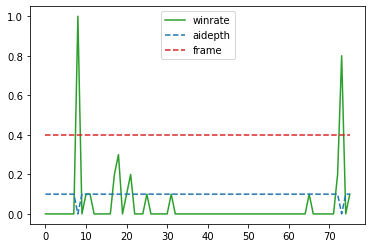

Selfplay
Acquiring min. 400 board states!
Loaded 100 boards from temp/selfplay0.dat.
Loaded 100 boards from temp/selfplay0.dat.
Loaded 100 boards from temp/selfplay0.dat.
Loaded 100 boards from temp/selfplay0.dat.
number of new states: 400
size of game rec: 29800
Training


PLoss=0.014709, VLoss=0.853027, Pvalloss=0.120485, Vvalloss=1.462321
PLoss=0.014703, VLoss=0.847207, Pvalloss=0.120188, Vvalloss=1.427545
PLoss=0.014438, VLoss=0.843110, Pvalloss=0.119388, Vvalloss=1.397433

Pitting
0 1
0 2
0 3
1 4
1 5
1 6
1 7
1 8
2 9
2 10
0.2


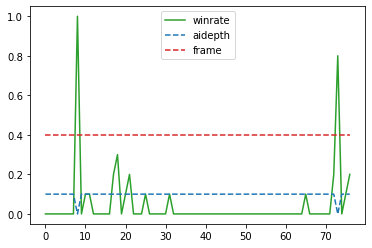

Selfplay
Acquiring min. 400 board states!
Loaded 100 boards from temp/selfplay0.dat.
Loaded 100 boards from temp/selfplay0.dat.
Loaded 100 boards from temp/selfplay0.dat.


In [ ]:

stage = 1

while True:

    
    # Evaluate/Pit
    if stage==0:
        print('Pitting')
        nsearches = 150 if depthminimax>0 else 1
        winrate = pit(MultiMCTS(nparallel=5, nsearches=nsearches, net=net, params={'useQ': False, 'cuncert': 0}), ClassicAI(depth=depthminimax), n=10, nrnd=2, frame=FRAME, verbose=1)
        print(winrate)
        winrates.append(winrate)
        mmdepths.append(depthminimax)
        frames.append(FRAME)
        plt.plot(winrates, 'C2', label='winrate')
        plt.plot(np.array(mmdepths)/10, 'C0--', label='aidepth')
        plt.plot(np.array(frames)/10, 'C3--', label='frame')
        plt.legend()
        plt.show()
        if depthminimax >= 1 and winrate>=0.7 and FRAME>0:
            FRAME = max(FRAME-2, 0)
            depthminimax = 1
            print(f'Changing frame to {FRAME}')
        elif winrate>=0.7 and depthminimax<1:
                depthminimax += 1
                print(f'Changing minimax depth to {depthminimax}')
        stage = 1
    
    
    # Selfplay
    if stage==1:
        print('Selfplay')
        #newgames = selfplay_batched(BatchMCTS(nparallel=50, nsearches=100, net=net, params={'useQ': True, 'cuncert': 4}), nstates=1000, frame=FRAME, verbose=1)
        newgames = load_selfplay(400)
        game_rec = newgames + game_rec
        print('number of new states:', len(newgames))
        print('size of game rec:', len(game_rec))
        stage=2
    
    
    
    # Train
    if stage==2:
        print('Training')
        train(net,  game_rec[:30000], iterations=300, verbose=1) # , teachers=[net1, net2, net3]
        torch.save(net.state_dict(),  'net_temp.dat')
        stage = 0
        
# NACH 4000 GEPSPIELTEN ZUSTÄNDEN DER ERSTE GEWINN GEGEN MINIMAX!!

In [ ]:
# Todo:
# + p-loss als solchen kennzeichnen, val-p-loss anzeigen
# + alphas als extra netz??
# + ensemble??

In [54]:
game_rec = game_rec+game_rec_leg

In [ ]:

#net = Net13x13()
train(net, game_rec+game_rec_leg, [], iterations=1000, verbose=1) # , teachers=[net1, net2, net3]
torch.save(net.state_dict(), 'net_temp.dat')

In [ ]:
k = 2
game_rec[k].v, game_rec[k].addv[:5]

In [ ]:
net.predict(game_rec[k].b)[-1][:5]

In [ ]:
k=0
b=game_rec[k].b
p=game_rec[k].p
p = np.sum([ p[k]*onehot2D((i,j), (N,N)) for k, (i,j) in enumerate(np.argwhere(b==0)) ], axis=0)

show_board(p, cmap='cividis', numbers=True)

In [ ]:
show_board(b, numbers=True)

In [21]:
game_rec=[]